## Combi rna_S3.0_cluster_allcells

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy

sc.set_figure_params(figsize=(4, 4))
def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/cluster/'

## Combi
### Read in dataset from rna_S1_preprocessing

In [2]:
adata = sc.read('S1_rna_counts_adata.h5ad')
adata.X.shape

(55409, 35220)

### Read in dataset + souporcell matrix (maternal+fetal+blood)

In [3]:
adata.obs_names = adata.obs_names 

In [4]:
adata.obs['sample_barcode'] = adata.obs_names

In [5]:
adata.obs.head()

sample    stage donor_id  \
Pla_HDBR11345029_AAACCCAAGACATCAA  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAAGCTTAAGA  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAAGGTTATAG  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCACAGGTCTCG  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAGTTACACAC  Pla_HDBR11345029  day2_UI   Hrv107   

                                   percent_mito  n_counts  n_genes batch  \
Pla_HDBR11345029_AAACCCAAGACATCAA      0.053661    6802.0     2858     0   
Pla_HDBR11345029_AAACCCAAGCTTAAGA      0.017683    4920.0     2162     0   
Pla_HDBR11345029_AAACCCAAGGTTATAG      0.038199   14346.0     3457     0   
Pla_HDBR11345029_AAACCCACAGGTCTCG      0.039867    2408.0     1437     0   
Pla_HDBR11345029_AAACCCAGTTACACAC      0.016942   25617.0     4789     0   

                                  low_ncounts high_mito low_ncounts_high_mito  \
Pla_HDBR11345029_AAACCCAAGACATCAA       False     False                 False   
Pla_HDBR11345029_AAACCCAAGCTTAAGA       False     False                 False   
Pla_HDBR11345029_AAACCCAAGGTTATAG       False     False                 False   
Pla_HDBR11345029_AAACCCACAGGTCTCG       False     False                 False   
Pla_HDBR11345029_AAACCCAGTTACACAC       False     False                 False   

                                   ...  G2M_score  phase  scrublet_score  \
Pla_HDBR11345029_AAACCCAAGACATCAA  ...   0.047255    G2M        0.093793   
Pla_HDBR11345029_AAACCCAAGCTTAAGA  ...  -0.086672     G1        0.029553   
Pla_HDBR11345029_AAACCCAAGGTTATAG  ...  -0.395512     G1        0.107438   
Pla_HDBR11345029_AAACCCACAGGTCTCG  ...  -0.080785     G1        0.150142   
Pla_HDBR11345029_AAACCCAGTTACACAC  ...  -0.308954     G1        0.097458   

                                   scrublet_cluster_score    zscore   bh_pval  \
Pla_HDBR11345029_AAACCCAAGACATCAA                0.107438  0.780692  0.853423   
Pla_HDBR11345029_AAACCCAAGCTTAAGA                0.044248 -2.419891  0.999535   
Pla_HDBR11345029_AAACCCAAGGTTATAG                0.081462 -0.534988  0.999535   
Pla_HDBR11345029_AAACCCACAGGTCTCG                0.068430 -1.195056  0.999535   
Pla_HDBR11345029_AAACCCAGTTACACAC                0.088608 -0.173068  0.964031   

                                  bonf_pval  is_doublet  is_doublet_0.05  \
Pla_HDBR11345029_AAACCCAAGACATCAA       1.0       False            False   
Pla_HDBR11345029_AAACCCAAGCTTAAGA       1.0       False            False   
Pla_HDBR11345029_AAACCCAAGGTTATAG       1.0       False            False   
Pla_HDBR11345029_AAACCCACAGGTCTCG       1.0       False            False   
Pla_HDBR11345029_AAACCCAGTTACACAC       1.0       False            False   

                                                      sample_barcode  
Pla_HDBR11345029_AAACCCAAGACATCAA  Pla_HDBR11345029_AAACCCAAGACATCAA  
Pla_HDBR11345029_AAACCCAAGCTTAAGA  Pla_HDBR11345029_AAACCCAAGCTTAAGA  
Pla_HDBR11345029_AAACCCAAGGTTATAG  Pla_HDBR11345029_AAACCCAAGGTTATAG  
Pla_HDBR11345029_AAACCCACAGGTCTCG  Pla_HDBR11345029_AAACCCACAGGTCTCG  
Pla_HDBR11345029_AAACCCAGTTACACAC  Pla_HDBR11345029_AAACCCAGTTACACAC  

[5 rows x 28 columns]

In [6]:
samplesX = list(np.unique(adata.obs['sample'])) 

In [7]:
samplesX

['Pla_HDBR11345029',
 'Pla_HDBR11345030',
 'Pla_HDBR11345033',
 'Pla_HDBR11345034']

### Add in souporcell clusters 'assignment' into object

In [8]:
data_dir='/nfs/team292/rh26/16_explant_sc_2D9_stars_combine/'

In [9]:
# sample to cluster dataframe
corr_clusters = {}

for sample in samplesX:
    print(sample)
    corr_clusters[sample] = pd.read_csv(data_dir+ 'souporcell/results/'+sample+'/clusters.tsv',  sep='\t')
    corr_clusters[sample]['sample_barcode'] = [sample+'_'+j for j in corr_clusters[sample]['barcode']]
    corr_clusters[sample].set_index('sample_barcode', drop=False, inplace=True)

Pla_HDBR11345029
Pla_HDBR11345030
Pla_HDBR11345033
Pla_HDBR11345034


In [10]:
corr_clusters[sample]

barcode   status assignment  \
sample_barcode                                                            
Pla_HDBR11345034_AAACCCAAGAAATTGC  AAACCCAAGAAATTGC  singlet          0   
Pla_HDBR11345034_AAACCCAAGCCATATC  AAACCCAAGCCATATC  singlet          0   
Pla_HDBR11345034_AAACCCAAGCGCCTCA  AAACCCAAGCGCCTCA  singlet          0   
Pla_HDBR11345034_AAACCCAAGGAGGTTC  AAACCCAAGGAGGTTC  doublet        0/2   
Pla_HDBR11345034_AAACCCAAGGAGTACC  AAACCCAAGGAGTACC  singlet          0   
...                                             ...      ...        ...   
Pla_HDBR11345034_TTTGTTGGTGGAGAAA  TTTGTTGGTGGAGAAA  singlet          0   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA  TTTGTTGGTGTTTGCA  singlet          2   
Pla_HDBR11345034_TTTGTTGGTTATGTGC  TTTGTTGGTTATGTGC  singlet          2   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC  TTTGTTGTCCTGGGAC  singlet          2   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG  TTTGTTGTCGTAGAGG  singlet          0   

                                   log_prob_singleton  log_prob_doublet  \
sample_barcode                                                            
Pla_HDBR11345034_AAACCCAAGAAATTGC         -964.849091       -975.360643   
Pla_HDBR11345034_AAACCCAAGCCATATC          -40.183538        -42.136942   
Pla_HDBR11345034_AAACCCAAGCGCCTCA          -90.425331        -91.789972   
Pla_HDBR11345034_AAACCCAAGGAGGTTC        -1137.133744      -1132.098959   
Pla_HDBR11345034_AAACCCAAGGAGTACC         -230.824634       -232.123504   
...                                               ...               ...   
Pla_HDBR11345034_TTTGTTGGTGGAGAAA         -572.875028       -578.935979   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA         -560.882403       -564.189338   
Pla_HDBR11345034_TTTGTTGGTTATGTGC         -371.039148       -375.988414   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC         -435.568605       -439.705461   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG         -611.925309       -613.914937   

                                      cluster0     cluster1     cluster2  \
sample_barcode                                                             
Pla_HDBR11345034_AAACCCAAGAAATTGC  -964.849091 -2153.112446 -1008.828587   
Pla_HDBR11345034_AAACCCAAGCCATATC   -40.183538   -81.413326   -46.578977   
Pla_HDBR11345034_AAACCCAAGCGCCTCA   -90.425331  -145.881475   -94.212978   
Pla_HDBR11345034_AAACCCAAGGAGGTTC -1137.133744 -2376.625578 -1163.392404   
Pla_HDBR11345034_AAACCCAAGGAGTACC  -230.824634  -528.911133  -242.794558   
...                                        ...          ...          ...   
Pla_HDBR11345034_TTTGTTGGTGGAGAAA  -572.875028 -1162.235327  -600.762423   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA  -580.751731 -1113.124279  -560.882403   
Pla_HDBR11345034_TTTGTTGGTTATGTGC  -400.120862  -930.767698  -371.039148   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC  -457.462222  -935.394713  -435.568605   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG  -611.925309 -1191.575362  -631.590423   

                                                      sample_barcode  
sample_barcode                                                        
Pla_HDBR11345034_AAACCCAAGAAATTGC  Pla_HDBR11345034_AAACCCAAGAAATTGC  
Pla_HDBR11345034_AAACCCAAGCCATATC  Pla_HDBR11345034_AAACCCAAGCCATATC  
Pla_HDBR11345034_AAACCCAAGCGCCTCA  Pla_HDBR11345034_AAACCCAAGCGCCTCA  
Pla_HDBR11345034_AAACCCAAGGAGGTTC  Pla_HDBR11345034_AAACCCAAGGAGGTTC  
Pla_HDBR11345034_AAACCCAAGGAGTACC  Pla_HDBR11345034_AAACCCAAGGAGTACC  
...                                                              ...  
Pla_HDBR11345034_TTTGTTGGTGGAGAAA  Pla_HDBR11345034_TTTGTTGGTGGAGAAA  
Pla_HDBR11345034_TTTGTTGGTGTTTGCA  Pla_HDBR11345034_TTTGTTGGTGTTTGCA  
Pla_HDBR11345034_TTTGTTGGTTATGTGC  Pla_HDBR11345034_TTTGTTGGTTATGTGC  
Pla_HDBR11345034_TTTGTTGTCCTGGGAC  Pla_HDBR11345034_TTTGTTGTCCTGGGAC  
Pla_HDBR11345034_TTTGTTGTCGTAGAGG  Pla_HDBR11345034_TTTGTTGTCGTAGAGG  

[17648 rows x 9 columns]

In [11]:
adata.obs['sample_barcode'] = adata.obs.index

In [12]:
adata.obs.head()

sample    stage donor_id  \
Pla_HDBR11345029_AAACCCAAGACATCAA  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAAGCTTAAGA  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAAGGTTATAG  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCACAGGTCTCG  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAGTTACACAC  Pla_HDBR11345029  day2_UI   Hrv107   

                                   percent_mito  n_counts  n_genes batch  \
Pla_HDBR11345029_AAACCCAAGACATCAA      0.053661    6802.0     2858     0   
Pla_HDBR11345029_AAACCCAAGCTTAAGA      0.017683    4920.0     2162     0   
Pla_HDBR11345029_AAACCCAAGGTTATAG      0.038199   14346.0     3457     0   
Pla_HDBR11345029_AAACCCACAGGTCTCG      0.039867    2408.0     1437     0   
Pla_HDBR11345029_AAACCCAGTTACACAC      0.016942   25617.0     4789     0   

                                  low_ncounts high_mito low_ncounts_high_mito  \
Pla_HDBR11345029_AAACCCAAGACATCAA       False     False                 False   
Pla_HDBR11345029_AAACCCAAGCTTAAGA       False     False                 False   
Pla_HDBR11345029_AAACCCAAGGTTATAG       False     False                 False   
Pla_HDBR11345029_AAACCCACAGGTCTCG       False     False                 False   
Pla_HDBR11345029_AAACCCAGTTACACAC       False     False                 False   

                                   ...  G2M_score  phase  scrublet_score  \
Pla_HDBR11345029_AAACCCAAGACATCAA  ...   0.047255    G2M        0.093793   
Pla_HDBR11345029_AAACCCAAGCTTAAGA  ...  -0.086672     G1        0.029553   
Pla_HDBR11345029_AAACCCAAGGTTATAG  ...  -0.395512     G1        0.107438   
Pla_HDBR11345029_AAACCCACAGGTCTCG  ...  -0.080785     G1        0.150142   
Pla_HDBR11345029_AAACCCAGTTACACAC  ...  -0.308954     G1        0.097458   

                                   scrublet_cluster_score    zscore   bh_pval  \
Pla_HDBR11345029_AAACCCAAGACATCAA                0.107438  0.780692  0.853423   
Pla_HDBR11345029_AAACCCAAGCTTAAGA                0.044248 -2.419891  0.999535   
Pla_HDBR11345029_AAACCCAAGGTTATAG                0.081462 -0.534988  0.999535   
Pla_HDBR11345029_AAACCCACAGGTCTCG                0.068430 -1.195056  0.999535   
Pla_HDBR11345029_AAACCCAGTTACACAC                0.088608 -0.173068  0.964031   

                                  bonf_pval  is_doublet  is_doublet_0.05  \
Pla_HDBR11345029_AAACCCAAGACATCAA       1.0       False            False   
Pla_HDBR11345029_AAACCCAAGCTTAAGA       1.0       False            False   
Pla_HDBR11345029_AAACCCAAGGTTATAG       1.0       False            False   
Pla_HDBR11345029_AAACCCACAGGTCTCG       1.0       False            False   
Pla_HDBR11345029_AAACCCAGTTACACAC       1.0       False            False   

                                                      sample_barcode  
Pla_HDBR11345029_AAACCCAAGACATCAA  Pla_HDBR11345029_AAACCCAAGACATCAA  
Pla_HDBR11345029_AAACCCAAGCTTAAGA  Pla_HDBR11345029_AAACCCAAGCTTAAGA  
Pla_HDBR11345029_AAACCCAAGGTTATAG  Pla_HDBR11345029_AAACCCAAGGTTATAG  
Pla_HDBR11345029_AAACCCACAGGTCTCG  Pla_HDBR11345029_AAACCCACAGGTCTCG  
Pla_HDBR11345029_AAACCCAGTTACACAC  Pla_HDBR11345029_AAACCCAGTTACACAC  

[5 rows x 28 columns]

In [13]:
def add_corr_id(adata_obj, cell_id):
    
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    #print('sample',sample, 'barcode', cell_id)
    
    if curr_sample in samplesX:
        #extracts the table contained in the indicated key of the dictionary
        curr_corr_table = corr_clusters[curr_sample]
        
        if (cell_id in list(curr_corr_table.index)): #checking that the cells are into the data
            curr_assign = corr_clusters[curr_sample].loc[cell_id,'assignment']
            #print('returning',curr_assign)
            return(curr_assign)

        else:
            # cell barcode is filtered by bigtable
            return('filtered')
    else:
        return('NA')

In [14]:
%%time

adata.obs['assignment'] = adata.obs['sample_barcode'].apply(lambda x: add_corr_id(adata,x))

CPU times: user 1min 3s, sys: 0 ns, total: 1min 3s
Wall time: 1min 3s


In [15]:
adata.obs['assignment']

Pla_HDBR11345029_AAACCCAAGACATCAA    0/1
Pla_HDBR11345029_AAACCCAAGCTTAAGA      1
Pla_HDBR11345029_AAACCCAAGGTTATAG      1
Pla_HDBR11345029_AAACCCACAGGTCTCG      1
Pla_HDBR11345029_AAACCCAGTTACACAC      0
                                    ... 
Pla_HDBR11345034_TTTGTTGGTGGAGAAA      0
Pla_HDBR11345034_TTTGTTGGTGTTTGCA      2
Pla_HDBR11345034_TTTGTTGGTTATGTGC      2
Pla_HDBR11345034_TTTGTTGTCCTGGGAC      2
Pla_HDBR11345034_TTTGTTGTCGTAGAGG      0
Name: assignment, Length: 55409, dtype: object

In [16]:
adata.obs.head()

sample    stage donor_id  \
Pla_HDBR11345029_AAACCCAAGACATCAA  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAAGCTTAAGA  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAAGGTTATAG  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCACAGGTCTCG  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAGTTACACAC  Pla_HDBR11345029  day2_UI   Hrv107   

                                   percent_mito  n_counts  n_genes batch  \
Pla_HDBR11345029_AAACCCAAGACATCAA      0.053661    6802.0     2858     0   
Pla_HDBR11345029_AAACCCAAGCTTAAGA      0.017683    4920.0     2162     0   
Pla_HDBR11345029_AAACCCAAGGTTATAG      0.038199   14346.0     3457     0   
Pla_HDBR11345029_AAACCCACAGGTCTCG      0.039867    2408.0     1437     0   
Pla_HDBR11345029_AAACCCAGTTACACAC      0.016942   25617.0     4789     0   

                                  low_ncounts high_mito low_ncounts_high_mito  \
Pla_HDBR11345029_AAACCCAAGACATCAA       False     False                 False   
Pla_HDBR11345029_AAACCCAAGCTTAAGA       False     False                 False   
Pla_HDBR11345029_AAACCCAAGGTTATAG       False     False                 False   
Pla_HDBR11345029_AAACCCACAGGTCTCG       False     False                 False   
Pla_HDBR11345029_AAACCCAGTTACACAC       False     False                 False   

                                   ...  phase  scrublet_score  \
Pla_HDBR11345029_AAACCCAAGACATCAA  ...    G2M        0.093793   
Pla_HDBR11345029_AAACCCAAGCTTAAGA  ...     G1        0.029553   
Pla_HDBR11345029_AAACCCAAGGTTATAG  ...     G1        0.107438   
Pla_HDBR11345029_AAACCCACAGGTCTCG  ...     G1        0.150142   
Pla_HDBR11345029_AAACCCAGTTACACAC  ...     G1        0.097458   

                                   scrublet_cluster_score    zscore   bh_pval  \
Pla_HDBR11345029_AAACCCAAGACATCAA                0.107438  0.780692  0.853423   
Pla_HDBR11345029_AAACCCAAGCTTAAGA                0.044248 -2.419891  0.999535   
Pla_HDBR11345029_AAACCCAAGGTTATAG                0.081462 -0.534988  0.999535   
Pla_HDBR11345029_AAACCCACAGGTCTCG                0.068430 -1.195056  0.999535   
Pla_HDBR11345029_AAACCCAGTTACACAC                0.088608 -0.173068  0.964031   

                                   bonf_pval is_doublet  is_doublet_0.05  \
Pla_HDBR11345029_AAACCCAAGACATCAA        1.0      False            False   
Pla_HDBR11345029_AAACCCAAGCTTAAGA        1.0      False            False   
Pla_HDBR11345029_AAACCCAAGGTTATAG        1.0      False            False   
Pla_HDBR11345029_AAACCCACAGGTCTCG        1.0      False            False   
Pla_HDBR11345029_AAACCCAGTTACACAC        1.0      False            False   

                                                      sample_barcode  \
Pla_HDBR11345029_AAACCCAAGACATCAA  Pla_HDBR11345029_AAACCCAAGACATCAA   
Pla_HDBR11345029_AAACCCAAGCTTAAGA  Pla_HDBR11345029_AAACCCAAGCTTAAGA   
Pla_HDBR11345029_AAACCCAAGGTTATAG  Pla_HDBR11345029_AAACCCAAGGTTATAG   
Pla_HDBR11345029_AAACCCACAGGTCTCG  Pla_HDBR11345029_AAACCCACAGGTCTCG   
Pla_HDBR11345029_AAACCCAGTTACACAC  Pla_HDBR11345029_AAACCCAGTTACACAC   

                                  assignment  
Pla_HDBR11345029_AAACCCAAGACATCAA        0/1  
Pla_HDBR11345029_AAACCCAAGCTTAAGA          1  
Pla_HDBR11345029_AAACCCAAGGTTATAG          1  
Pla_HDBR11345029_AAACCCACAGGTCTCG          1  
Pla_HDBR11345029_AAACCCAGTTACACAC          0  

[5 rows x 29 columns]

In [17]:
adata.obs['assignment'].value_counts()

0      22852
1      15795
2       8951
0/1     2166
1/0     1741
0/2     1616
2/0     1358
1/2      500
2/1      430
Name: assignment, dtype: int64

In [18]:
adata.obs['donor_id'].value_counts()

Hrv107    36206
Hrv124    19203
Name: donor_id, dtype: int64

In [19]:
sc.pp.filter_genes(adata, min_counts=3)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


#Remove cc genes
#ccgs defined in M1
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

##  Identify HVGs

In [20]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3",
    batch_key="donor_id"
)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [21]:
# subset object for latter
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

## Normalize optional==optional

## Load latent space scVI from rna_S2_integrate_scVI_sc


In [22]:
# n_latent_value 10
X_scVI = pd.read_csv('/lustre/scratch117/cellgen/team292/rh26/16_explant_sc_2D9_stars_combine/sc_combi_scVI/20220423_sc_combi_obsm_with_scVI_latent_representation_n_10_corrected_by_donor.csv', index_col=0)
adata.obsm["X_scVI"] = X_scVI.to_numpy()

## Clustering

In [23]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.4)

... storing 'assignment' as categorical


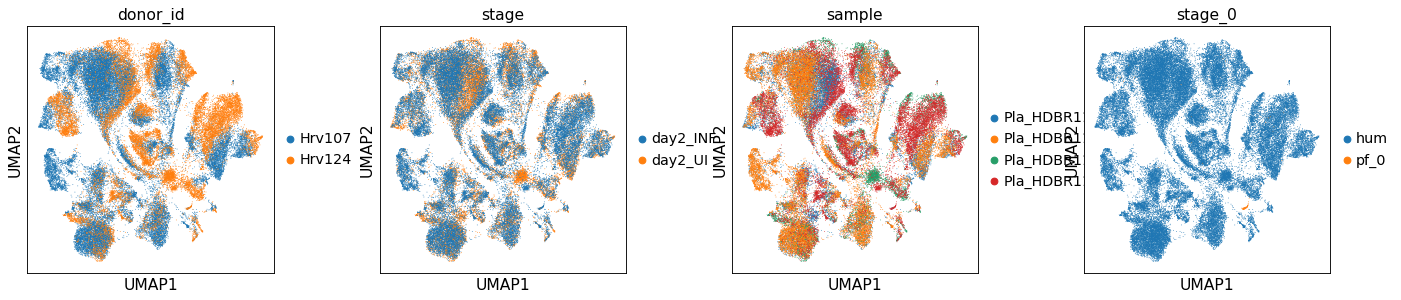

In [24]:
sc.pl.umap(
    adata,
    color=['donor_id',  'stage', 'sample', 'stage_0'], frameon=True, wspace = 0.3, save='_scVI_n_10.pdf'
)

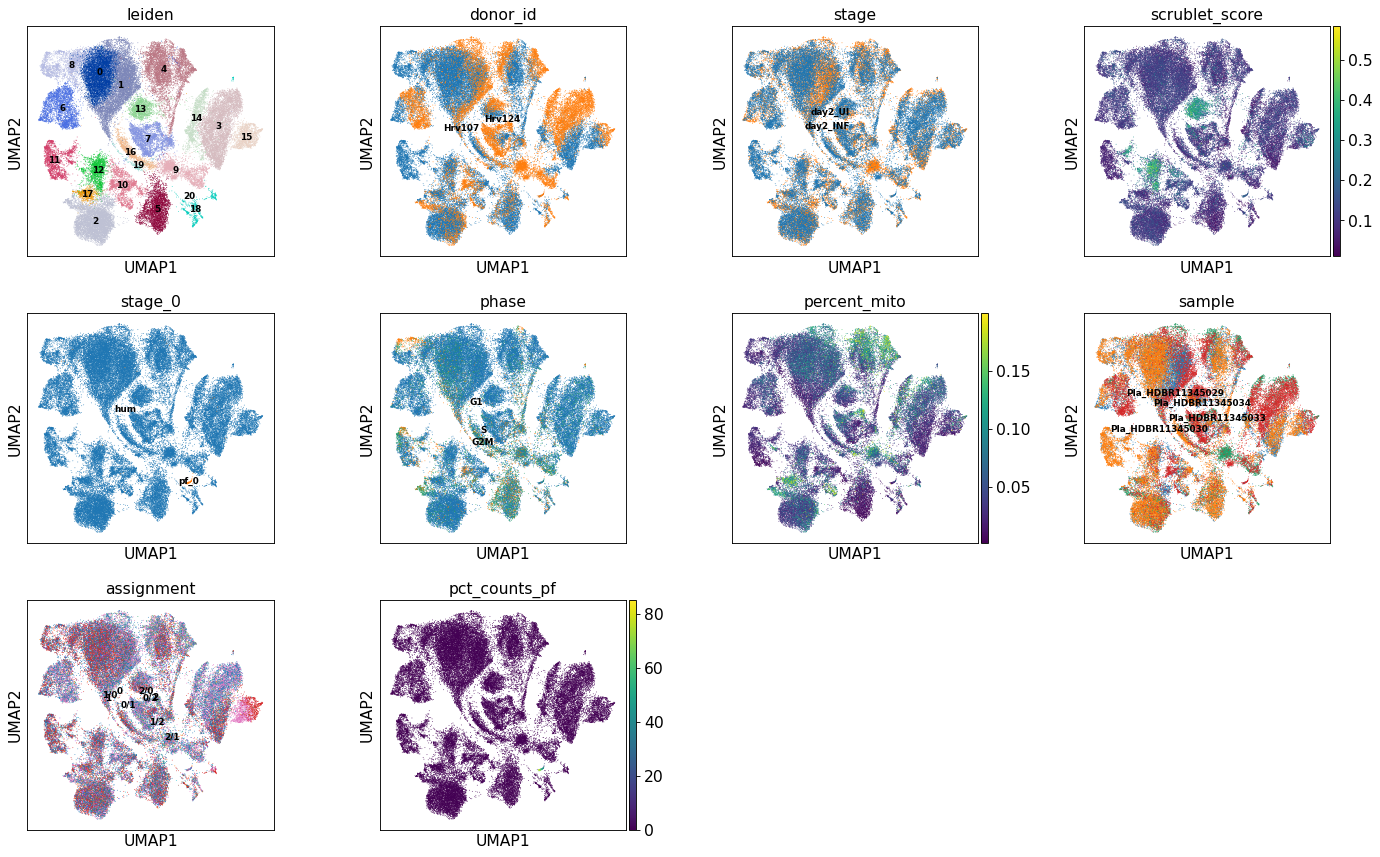

In [25]:
#resolution=0.6 OK
sc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(
    adata,
    color=['leiden', 'donor_id', 'stage', 'scrublet_score', 'stage_0', 'phase', 'percent_mito', 'sample', 'assignment', 'pct_counts_pf'], legend_loc='on data',legend_fontsize=8,
    frameon=True,  wspace = 0.3
)

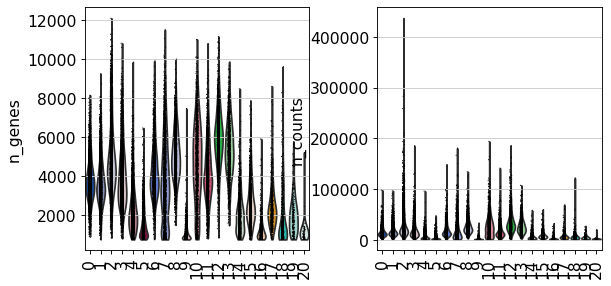

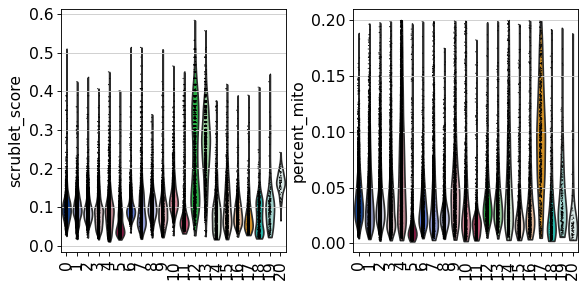

In [26]:
# identify lowQC
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='leiden', rotation=90)
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='leiden', rotation=90)

## Check maternal-fetal genotypes in individual samples

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


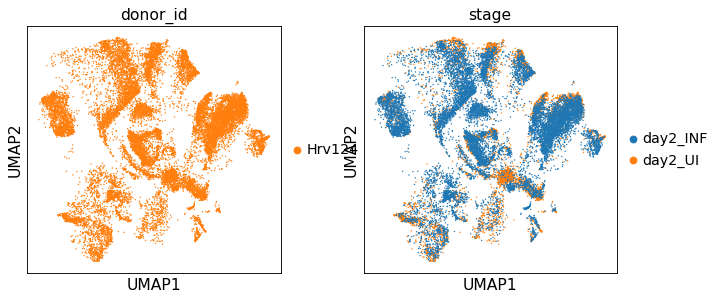

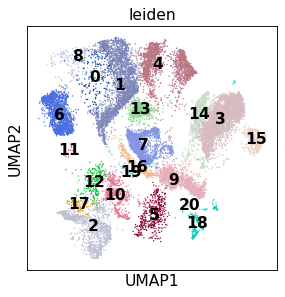

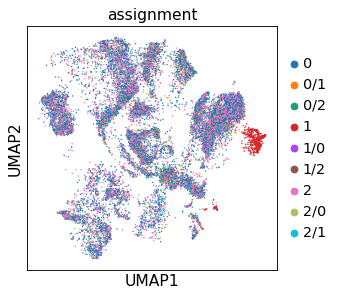

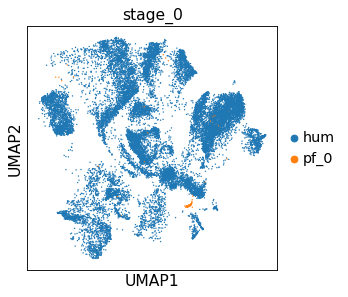

In [27]:
sample2 = adata[adata.obs['donor_id'] == 'Hrv124']
#clustering
sc.pl.umap(sample2, color=['donor_id','stage'])
#clustering
sc.pl.umap(sample2, color=['leiden'],legend_loc='on data')
sc.pl.umap(sample2, color=['assignment'])
sc.pl.umap(sample2, color=['stage_0'])

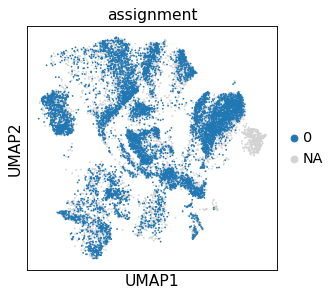

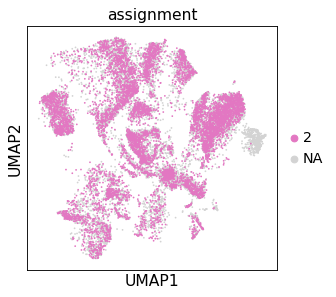

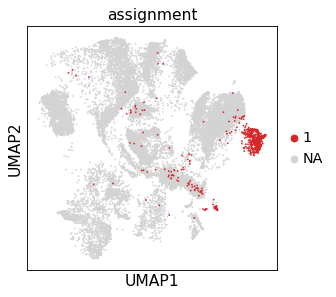

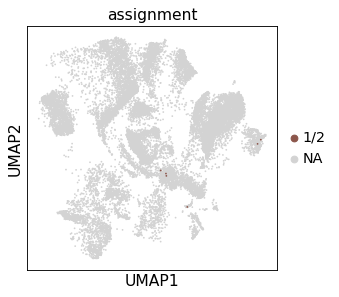

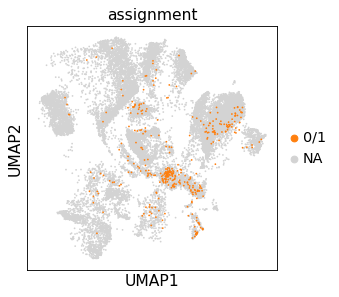

In [28]:
sc.pl.umap(sample2, color=['assignment' ], groups='0', size=10)
sc.pl.umap(sample2, color=['assignment' ], groups='2',size=10)
sc.pl.umap(sample2, color=['assignment' ], groups='1',size=10)
sc.pl.umap(sample2, color=['assignment' ], groups='1/2',size=10)
sc.pl.umap(sample2, color=['assignment' ], groups='0/1',size=10)

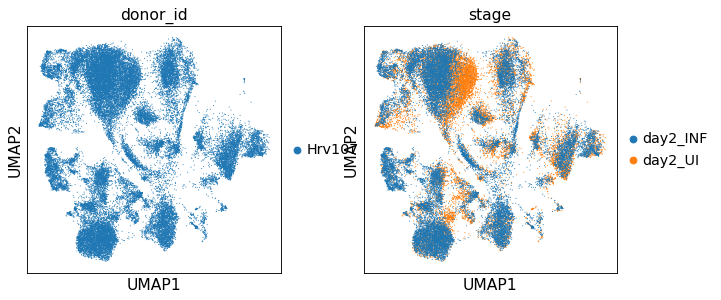

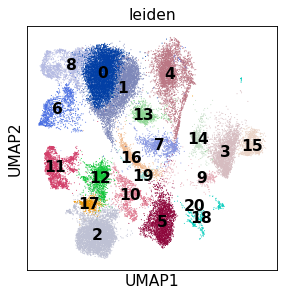

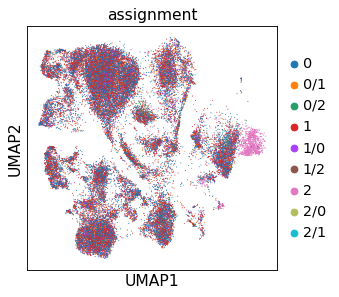

In [29]:
sample1 = adata[adata.obs['donor_id'] == 'Hrv107']
#clustering
sc.pl.umap(sample1, color=['donor_id','stage'])
#clustering
sc.pl.umap(sample1, color=['leiden'],legend_loc='on data')
sc.pl.umap(sample1, color=['assignment'])

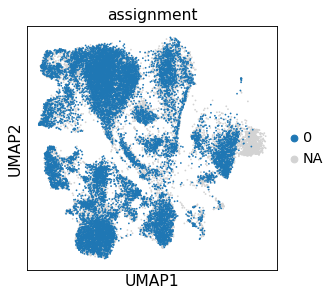

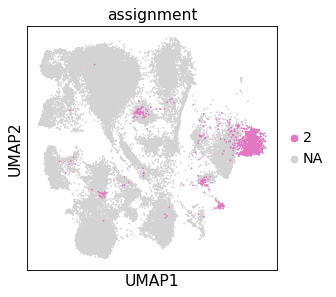

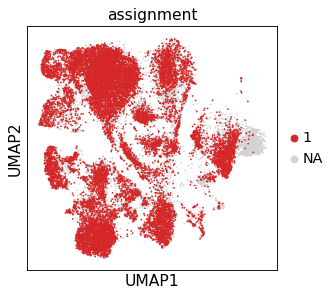

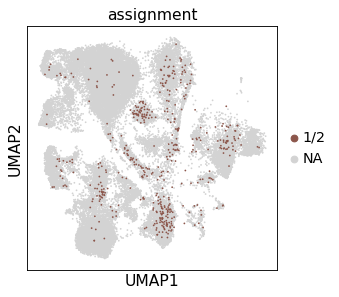

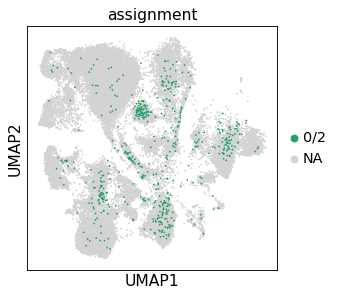

In [30]:
sc.pl.umap(sample1, color=['assignment' ], groups='0', size=10)
sc.pl.umap(sample1, color=['assignment' ], groups='2',size=10)
sc.pl.umap(sample1, color=['assignment' ], groups='1',size=10)
sc.pl.umap(sample1, color=['assignment' ], groups='1/2',size=10)
sc.pl.umap(sample1, color=['assignment' ], groups='0/2',size=10)

## Add in MF identity into object

In [31]:
def MFidentity(adata_obj, cell_id):

    curr_id = adata_obj.obs.loc[cell_id, 'assignment']
    curr_donor_id = adata_obj.obs.loc[cell_id, 'donor_id']
    
    if curr_donor_id == 'Hrv107':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Maternal')
        else:
            return('MF_doublets')
        
    if curr_donor_id == 'Hrv124':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '1':
            return('Maternal')
        else:
            return('MF_doublets')

In [32]:
adata.obs['sample_barcode'] = adata.obs_names

In [33]:
%%time
adata.obs['MFidentity'] = adata.obs['sample_barcode'].apply(lambda x: MFidentity(adata,x))

CPU times: user 949 ms, sys: 0 ns, total: 949 ms
Wall time: 949 ms


In [34]:
list(np.unique(adata.obs['MFidentity'])) 
adata.obs['MFidentity'].value_counts()

Fetal          45852
MF_doublets     7811
Maternal        1746
Name: MFidentity, dtype: int64

In [35]:
#Check
adata.obs.tail()

sample     stage donor_id  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGGTTATGTGC  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG  Pla_HDBR11345034  day2_INF   Hrv124   

                                   percent_mito  n_counts  n_genes batch  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA      0.069981   19934.0     4962     3   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA      0.048871   18907.0     4645     3   
Pla_HDBR11345034_TTTGTTGGTTATGTGC      0.013085    6343.0     2767     3   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC      0.025543   15151.0     3834     3   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG      0.021450   21259.0     4289     3   

                                  low_ncounts high_mito low_ncounts_high_mito  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA       False     False                 False   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA       False     False                 False   
Pla_HDBR11345034_TTTGTTGGTTATGTGC       False     False                 False   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC       False     False                 False   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG       False     False                 False   

                                   ...  scrublet_cluster_score    zscore  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA  ...                0.086420  0.128607   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA  ...                0.064799 -1.532468   
Pla_HDBR11345034_TTTGTTGGTTATGTGC  ...                0.086420  0.128607   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC  ...                0.086420  0.128607   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG  ...                0.089888  0.395032   

                                    bh_pval  bonf_pval  is_doublet  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA  0.927854        1.0       False   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA  1.000000        1.0       False   
Pla_HDBR11345034_TTTGTTGGTTATGTGC  0.927854        1.0       False   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC  0.927854        1.0       False   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG  0.927854        1.0       False   

                                   is_doublet_0.05  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA            False   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA            False   
Pla_HDBR11345034_TTTGTTGGTTATGTGC            False   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC            False   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG            False   

                                                      sample_barcode  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA  Pla_HDBR11345034_TTTGTTGGTGGAGAAA   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA  Pla_HDBR11345034_TTTGTTGGTGTTTGCA   
Pla_HDBR11345034_TTTGTTGGTTATGTGC  Pla_HDBR11345034_TTTGTTGGTTATGTGC   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC  Pla_HDBR11345034_TTTGTTGTCCTGGGAC   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG  Pla_HDBR11345034_TTTGTTGTCGTAGAGG   

                                   assignment  leiden MFidentity  
Pla_HDBR11345034_TTTGTTGGTGGAGAAA           0       3      Fetal  
Pla_HDBR11345034_TTTGTTGGTGTTTGCA           2       3      Fetal  
Pla_HDBR11345034_TTTGTTGGTTATGTGC           2       4      Fetal  
Pla_HDBR11345034_TTTGTTGTCCTGGGAC           2       6      Fetal  
Pla_HDBR11345034_TTTGTTGTCGTAGAGG           0       1      Fetal  

[5 rows x 31 columns]

... storing 'MFidentity' as categorical
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


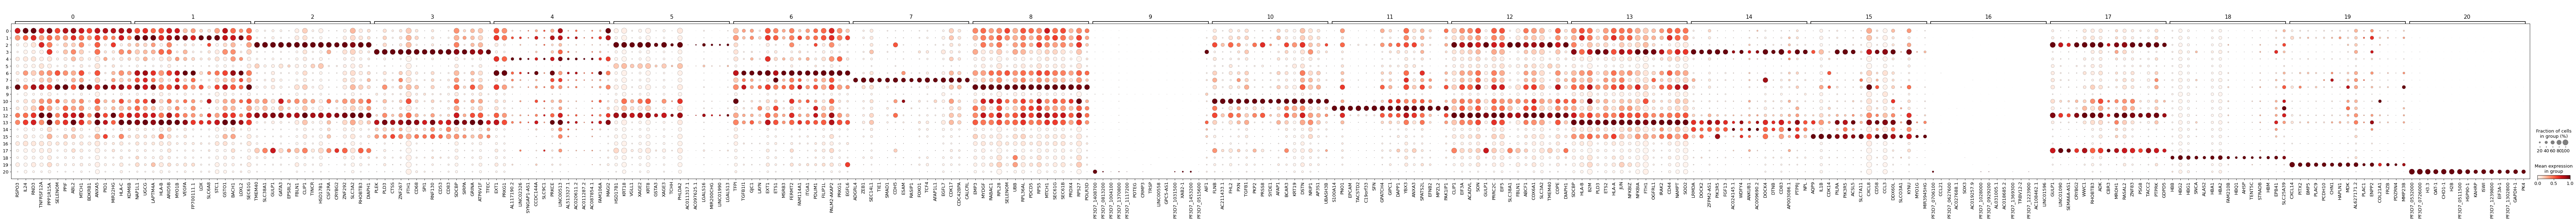

In [36]:
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=15, dendrogram=False, use_raw = False, standard_scale = 'var')

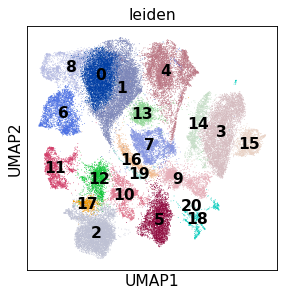

In [37]:
sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


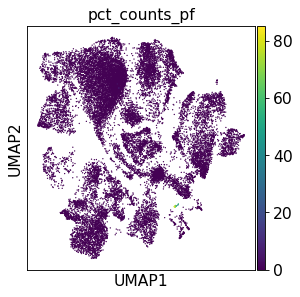

In [38]:
adata_day2_UI =adata[[i in ['day2_UI'] for i in adata.obs['stage']]]
sc.pl.umap(adata_day2_UI,  color=['pct_counts_pf'], legend_fontsize=12)

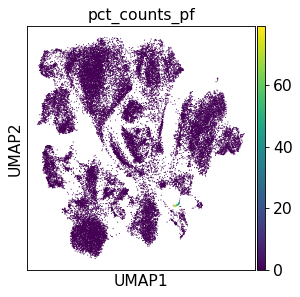

In [39]:
adata_day2_INF =adata[[i in ['day2_INF'] for i in adata.obs['stage']]]
sc.pl.umap(adata_day2_INF,  color=['pct_counts_pf'], legend_fontsize=12)

## Plot know marker_genes checking the clusters

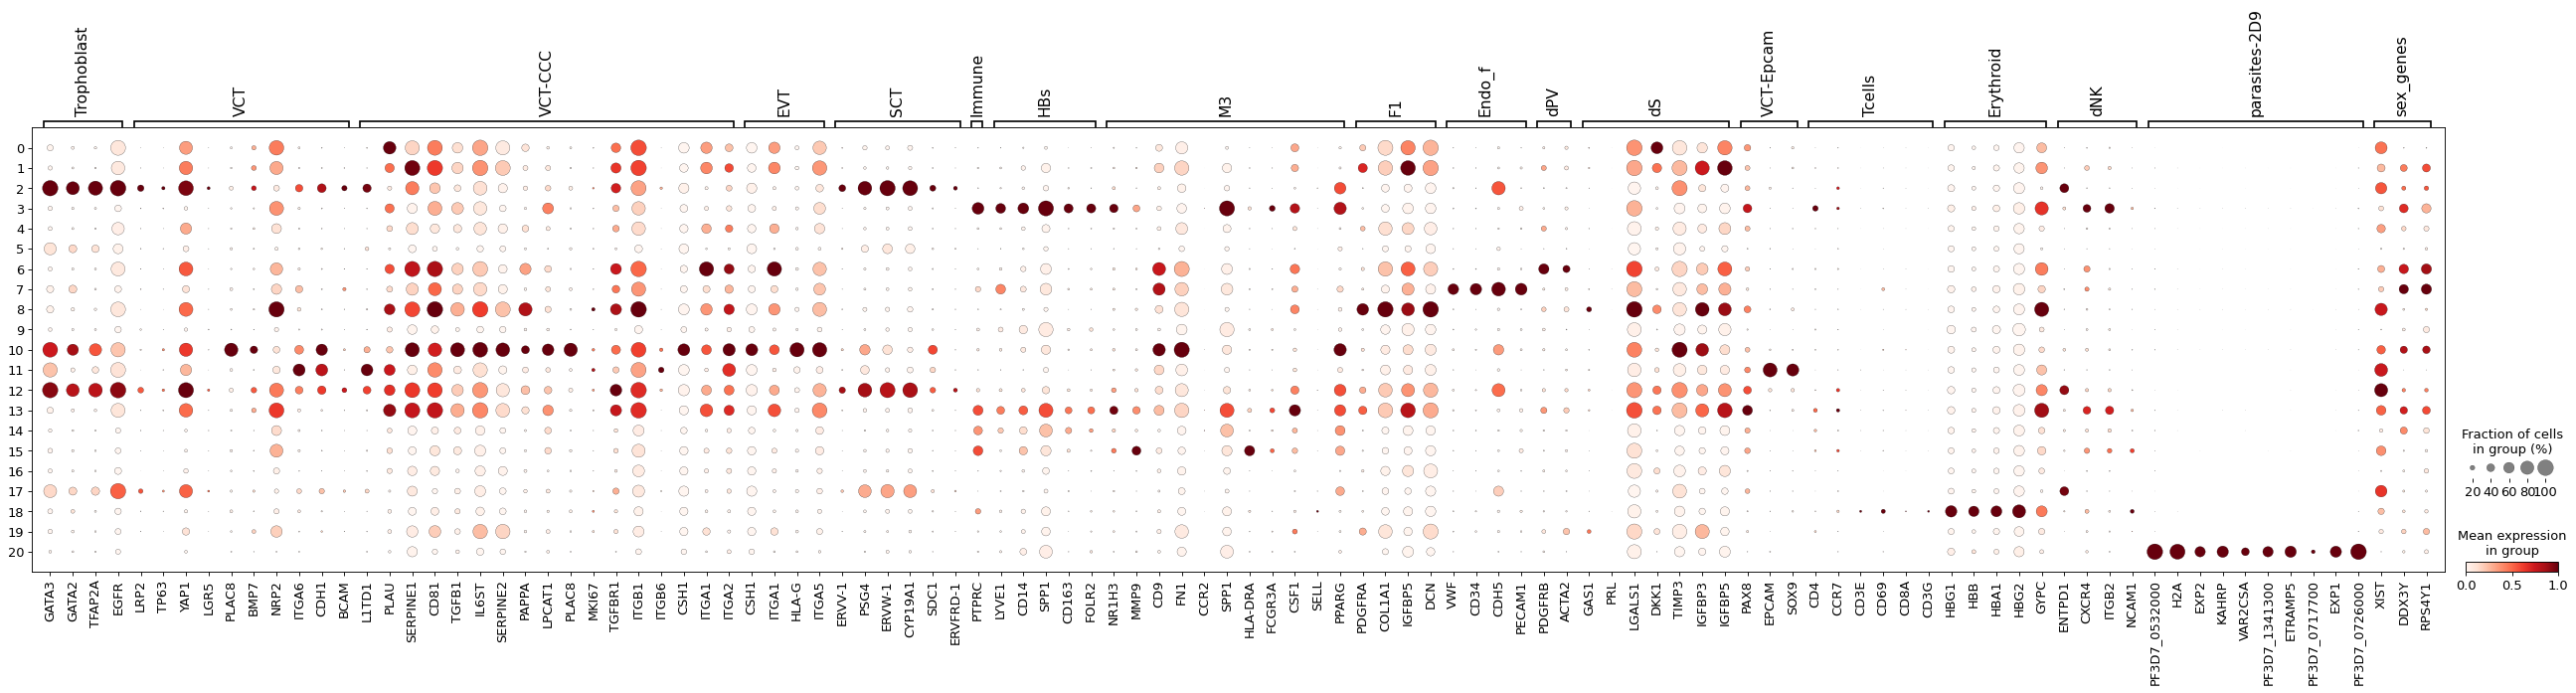

In [40]:
marker_genes = {
    'Trophoblast': {'GATA2', 'GATA3', 'TFAP2A', 'EGFR'},
    'VCT': {'TP63','ITGA6', 'LRP2', 'NRP2', 'BCAM', 'PLAC8', 'LGR5', 'YAP1', 'CDH1', 'BMP7'}, 
    'VCT-CCC': {'L1TD1', 'PLAC8','LPCAT1', 'SERPINE1', 'SERPINE2', 'PLAU','ITGB1', 'ITGB6','IL6ST', 'ITGA1', 'ITGA2','CD81','MKI67', 'CSH1', 'TGFB1', 'TGFBR1','PAPPA'},
    'EVT': {'HLA-G', 'CSH1', 'ITGA5', 'ITGA1'},
    'SCT':{'CYP19A1','PSG4', 'SDC1', 'ERVFRD-1','ERVW-1', 'ERVV-1' },
    'Immune':{'PTPRC'},
    'HBs':{'LYVE1', 'FOLR2','SPP1', 'CD14', 'CD163'},
    'M3':{'CD9','CCR2', 'SPP1','HLA-DRA', 'FCGR3A', 'FN1', 'MMP9','SELL', 'CSF1','NR1H3', 'PPARG'},
    'F1':{'DCN','IGFBP5', 'PDGFRA','COL1A1'},
    'Endo_f': {'CD34','PECAM1', 'CDH5', 'VWF'},
    'dPV': {'PDGFRB', 'ACTA2'},
    'dS': {'IGFBP3', 'PRL','DKK1', 'GAS1', 'IGFBP5', 'LGALS1', 'TIMP3'},
    'VCT-Epcam': {"EPCAM", 'PAX8', 'SOX9'},
    'Tcells': {"CD4",'CD3E', 'CD3G', 'CD69', 'CCR7', 'CD8A'},
    'Erythroid': {"GYPC", "HBA1", 'HBB', 'HBG2','HBG1'},
    'dNK':{'NCAM1', 'ENTPD1','ITGB2', 'CXCR4'},#, 'CD39=ENTPD1',
    'parasites-2D9':{'VAR2CSA', 'EXP1', 'EXP2', 'ETRAMP5','KAHRP','PF3D7_0726000','PF3D7_0532000', 'H2A',  'PF3D7_0717700','PF3D7_1341300'},
    'sex_genes':{'RPS4Y1','DDX3Y', 'XIST',}
}
sc.pl.dotplot(adata, marker_genes, groupby='leiden', use_raw=False, standard_scale = 'var')

## Annotate clusters as 'cluster' in object

... storing 'cluster' as categorical


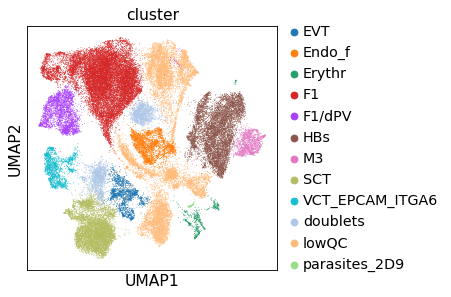

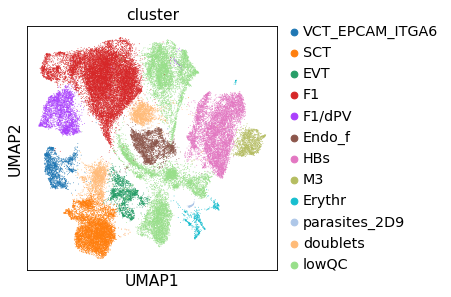

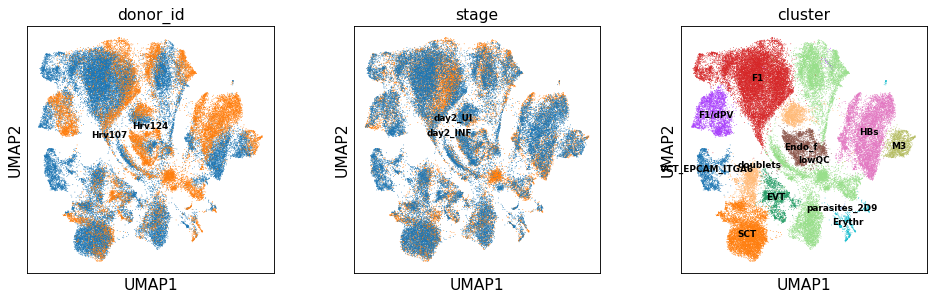

In [41]:
#n_latent=10
adata.obs['cluster'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['cluster'] == '0', 'cluster'] = 'F1'
adata.obs.at[adata.obs['cluster'] == '1', 'cluster'] = 'F1'
adata.obs.at[adata.obs['cluster'] == '2', 'cluster'] = 'SCT'
adata.obs.at[adata.obs['cluster'] == '3', 'cluster'] = 'HBs'
adata.obs.at[adata.obs['cluster'] == '4', 'cluster'] = 'lowQC'
adata.obs.at[adata.obs['cluster'] == '5', 'cluster'] = 'lowQC'
adata.obs.at[adata.obs['cluster'] == '6', 'cluster'] = 'F1/dPV'
adata.obs.at[adata.obs['cluster'] == '7', 'cluster'] = 'Endo_f'
adata.obs.at[adata.obs['cluster'] == '8', 'cluster'] = 'F1'
adata.obs.at[adata.obs['cluster'] == '9', 'cluster'] = 'lowQC'
adata.obs.at[adata.obs['cluster'] == '10', 'cluster'] = 'EVT'
adata.obs.at[adata.obs['cluster'] == '11', 'cluster'] = 'VCT_EPCAM_ITGA6'
adata.obs.at[adata.obs['cluster'] == '12', 'cluster'] = 'doublets'
adata.obs.at[adata.obs['cluster'] == '13', 'cluster'] = 'doublets'
adata.obs.at[adata.obs['cluster'] == '14', 'cluster'] = 'HBs'
adata.obs.at[adata.obs['cluster'] == '15', 'cluster'] = 'M3'
adata.obs.at[adata.obs['cluster'] == '16', 'cluster'] = 'lowQC'
adata.obs.at[adata.obs['cluster'] == '17', 'cluster'] = 'SCT'
adata.obs.at[adata.obs['cluster'] == '18', 'cluster'] = 'Erythr'
adata.obs.at[adata.obs['cluster'] == '19', 'cluster'] = 'lowQC'
adata.obs.at[adata.obs['cluster'] == '20', 'cluster'] = 'parasites_2D9'
set(adata.obs['cluster'])
sc.pl.umap(adata, color=['cluster'])
adata.obs['cluster'].cat.reorder_categories(['VCT_EPCAM_ITGA6','SCT', 'EVT','F1','F1/dPV','Endo_f', 'HBs', 'M3','Erythr','parasites_2D9','doublets', 'lowQC'], inplace=True)

sc.pl.umap(adata, color=['cluster'])
sc.pl.umap(adata, color=['donor_id', 'stage', 'cluster'], ncols = 3, legend_loc='on data', legend_fontsize=8, save='_combi.pdf')

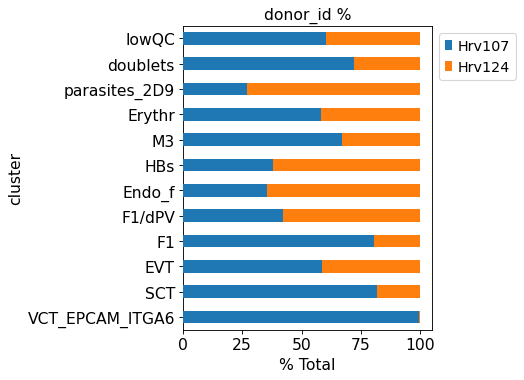

In [42]:
def Barplot(which_var, adata, var='cluster', height=5, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False,)
    else: 
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_xlabel('% Total')
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', dpi=300, orientation='landscape', format= 'pdf',  bbox_inches='tight')
Barplot('donor_id', adata)

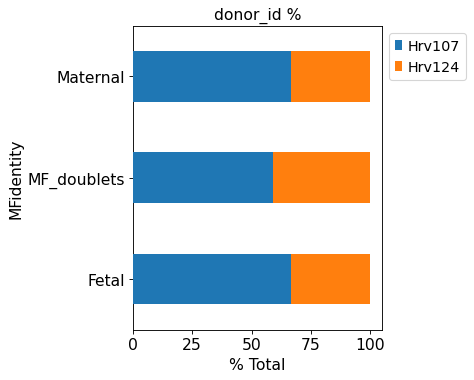

In [43]:
def Barplot(which_var, adata, var='MFidentity', height=5, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False,)
    else: 
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_xlabel('% Total')
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', dpi=300, orientation='landscape', format= 'pdf',  bbox_inches='tight')
Barplot('donor_id', adata)

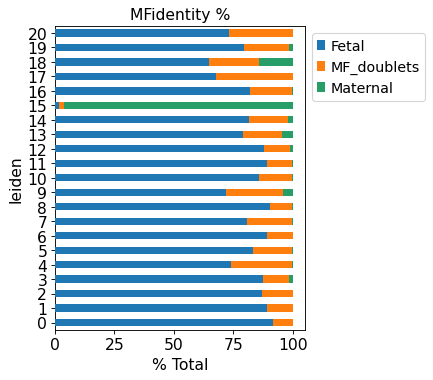

In [44]:
def Barplot(which_var, adata, var='leiden', height=5, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False,)
    else: 
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_xlabel('% Total')
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', dpi=300, orientation='landscape', format= 'pdf',  bbox_inches='tight')
Barplot('MFidentity', adata)

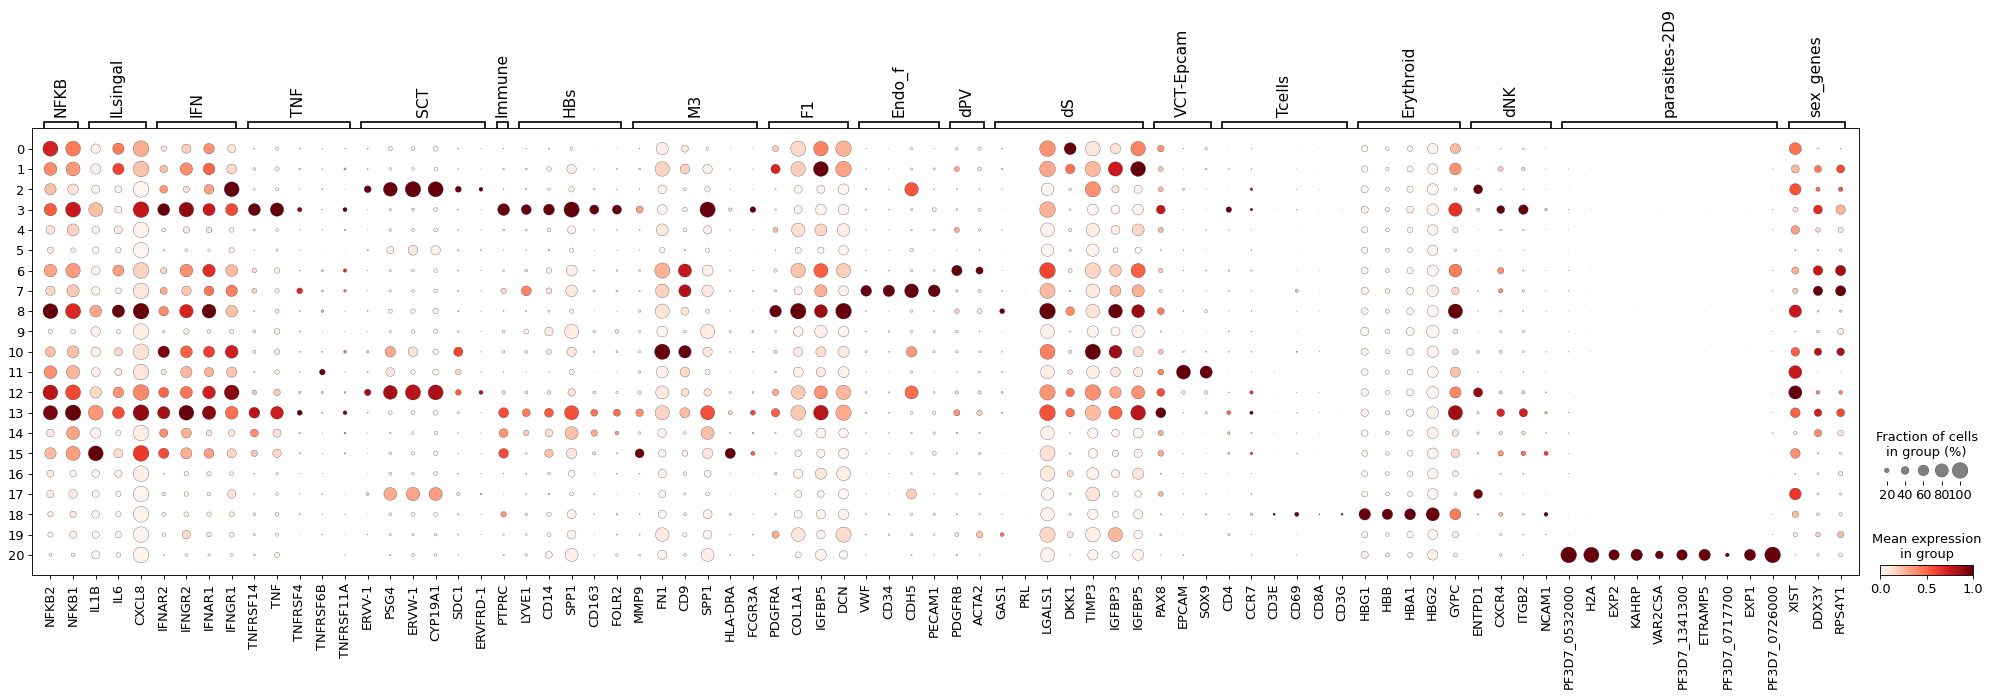

In [45]:
inflamm_genes = {
    'NFKB': {'NFKB1', 'NFKB2'},
    'ILsingal': {'CXCL8','IL1B', 'IL6'}, 
    'IFN': {'IFNGR1','IFNGR2','IFNAR2', 'IFNAR1'},
    'TNF': {'TNFRSF4','TNFRSF14','TNFRSF11A', 'TNFRSF6B', 'TNF'},
    'SCT':{'CYP19A1','PSG4', 'SDC1', 'ERVFRD-1','ERVW-1', 'ERVV-1' },
    'Immune':{'PTPRC'},
    'HBs':{'LYVE1', 'FOLR2','SPP1', 'CD14', 'CD163'},
    'M3':{'CD9', 'SPP1','HLA-DRA', 'FCGR3A', 'FN1', 'MMP9'},
    'F1':{'DCN','IGFBP5', 'PDGFRA','COL1A1'},
    'Endo_f': {'CD34','PECAM1', 'CDH5', 'VWF'},
    'dPV': {'PDGFRB', 'ACTA2'},
    'dS': {'IGFBP3', 'PRL','DKK1', 'GAS1', 'IGFBP5', 'LGALS1', 'TIMP3'},
    'VCT-Epcam': {"EPCAM", 'PAX8', 'SOX9'},
    'Tcells': {"CD4",'CD3E', 'CD3G', 'CD69', 'CCR7', 'CD8A'},
    'Erythroid': {"GYPC", "HBA1", 'HBB', 'HBG2','HBG1'},
    'dNK':{'NCAM1', 'ENTPD1','ITGB2', 'CXCR4'},#, 'CD39=ENTPD1',
    'parasites-2D9':{'VAR2CSA', 'EXP1', 'EXP2', 'ETRAMP5','KAHRP','PF3D7_0726000','PF3D7_0532000', 'H2A',  'PF3D7_0717700','PF3D7_1341300'},
    'sex_genes':{'RPS4Y1','DDX3Y', 'XIST',}
}
sc.pl.dotplot(adata, inflamm_genes, groupby='leiden', use_raw=False, standard_scale = 'var')

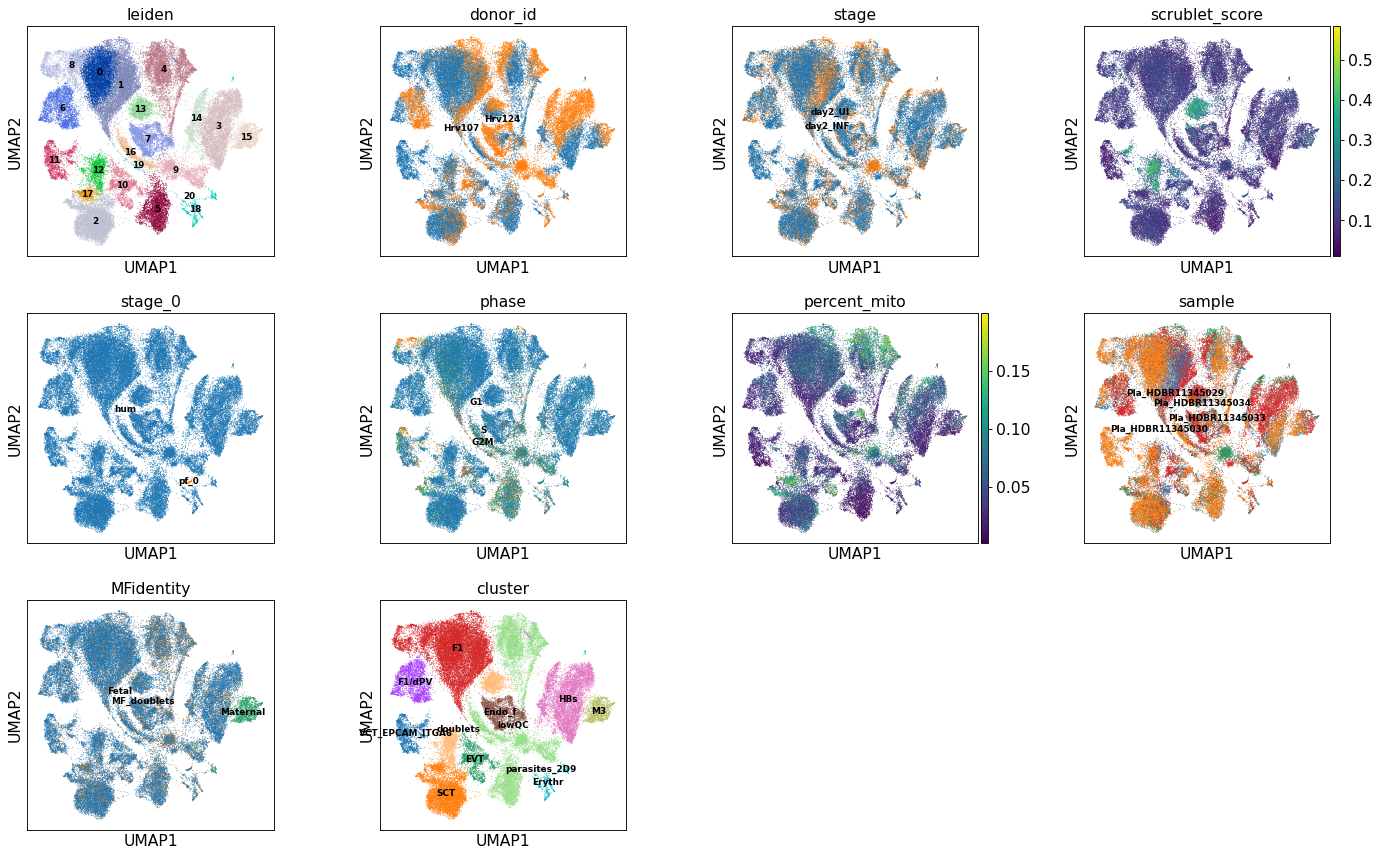

In [46]:
sc.pl.umap(
    adata,
    color=['leiden', 'donor_id', 'stage', 'scrublet_score', 'stage_0', 'phase', 'percent_mito', 'sample', 'MFidentity', 'cluster'], legend_loc='on data',legend_fontsize=8,
    frameon=True,  wspace = 0.3, save='_summary.pdf'
)

In [47]:
adata.obs.to_csv('S3_rna_cluster_annotate_1.csv')
adata.write('S3_rna_cluster_annotate_1.h5ad')

## Removed 'lowQC', 'doublets' cluster, re-save object in raw counts as 'S3_rna_cluster_annotate_1_clean.h5ad'

In [48]:
adata = adata[adata.obs['cluster'] != 'lowQC']
adata

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 43794 × 35220
    obs: 'sample', 'stage', 'donor_id', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'n_genes_by_counts', 'total_counts', 'total_counts_hum', 'pct_counts_hum', 'total_counts_pf', 'pct_counts_pf', 'stage_0', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'is_doublet_0.05', 'sample_barcode', 'assignment', 'leiden', 'MFidentity', 'cluster'
    var: 'gene_ids', 'feature_types', 'n_cells', 'hum', 'pf', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'donor_id_colors', 'sample_colors', 'stage_colors', 'hvg', 'neighbors', 'umap', 'stage_0_colors', 'leiden', 'leiden_colors', 'phase_colors', 'assignment_colors', 'rank_genes_groups', 'cluster_colors

In [ ]:
adata = adata[adata.obs['cluster'] != 'doublets']
adata

In [ ]:
adata.obs['cluster'].values.describe()

In [51]:
adata.write('S3_rna_cluster_annotate_1_clean.h5ad')

==========================================================================================================================================================